## Identify spatial genes with scGCO

In [1]:

from scGCO import *
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Tutorial with Rep11 of MOB 
## This is a step-by-step instruction on running the main functionalities of scGCO.
* <font size=4><mark>Step 1-5:</mark> perform genome-scale identification of spatially variably genes. </font>
* <font size=4><mark>Step 6-7:</mark> visualize and save identified spatial variably genes.</font>
* <font size=4><mark>Step 8:</mark> perform graph cuts on a single genes to visualize its spatial patterns.</font>



## **Step 1:**

### **Read in raw data and perform standard normalization.**

In [3]:
j=11
unary_scale_factor=100
label_cost=10
algorithm='expansion'
ff = '../../data/Raw_data/MOB-breast_cancer/Rep'+str(j)+'_MOB_count_matrix-1.tsv'
locs,data=read_spatial_expression(ff,sep='\t',num_exp_genes=0.01, num_exp_spots=0.05, min_expression=1)

data_norm = normalize_count_cellranger(data)
print('Rep{}_processing: {}'.format(j,data_norm.shape))

raw data dim: (262, 16218)
Rep11_processing: (259, 12522)


## **Step 2:**  

### Create complete undiected graph with connecting spatial spots/cells 

In [4]:
exp= data_norm.iloc[:,0]
cellGraph= create_graph_with_weight(locs, exp)

Text(0.5, 1.0, 'CellGraph')

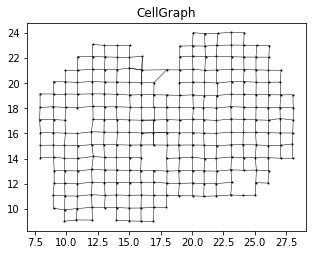

In [6]:
fig, ax= plt.subplots(1,1,figsize=(5,5)) #, dpi=300)
ax.set_aspect('equal')

exp= data_norm.iloc[:,0].values
cellGraph = create_graph_with_weight(locs, exp)
ax.scatter(locs[:,0], locs[:,1], s=1, color='black')
for i in np.arange(cellGraph.shape[0]):
    x = (locs[int(cellGraph[i,0]), 0], locs[int(cellGraph[i,1]), 0]) 
    y = (locs[int(cellGraph[i,0]), 1], locs[int(cellGraph[i,1]), 1])     
    ax.plot(x, y, color='black', linewidth=0.5)
    
plt.title('CellGraph')

<font size=3> **Recommended fill spots for Mouse olfactor bulb and Breast cancer:** </font>  
    <font size=2> &emsp; The undigraph connected all adjoining circular ‘spots’with a diameter of 100 µm  and finally formed a grid, where at each spot the mRNA abundance of 10–100 cells. So we suggest filling missed or filtered sopts for getting more complete graph.   </font>  
    <font size=2> &emsp; *The user chooses the step for other datasets.*</font> 

In [10]:
locs_new,data_norm_new,newPoints=AddPoints_XY_and_update_data(locs,data_norm,cellGraph,axis=1)
print('Filled {} points'.format(len(newPoints)))
print('After filled points: ', data_norm_new.shape)

Filled 6 points
After filled points:  (265, 12522)


Text(0.5, 1.0, 'New CellGraph')

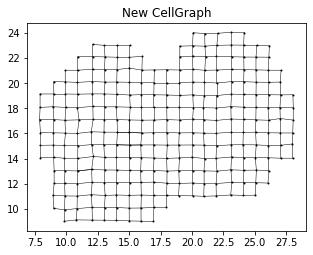

In [12]:
fig, ax= plt.subplots(1,1,figsize=(5,5)) #, dpi=300)
ax.set_aspect('equal')

exp_new = data_norm_new.iloc[:,0].values
cellGraph_new = create_graph_with_weight(locs_new, exp_new)
ax.scatter(locs_new[:,0], locs_new[:,1], s=1, color='black')
for i in np.arange(cellGraph_new.shape[0]):
    x = (locs_new[int(cellGraph_new[i,0]), 0], locs_new[int(cellGraph_new[i,1]), 0]) 
    y = (locs_new[int(cellGraph_new[i,0]), 1], locs_new[int(cellGraph_new[i,1]), 1])     
    ax.plot(x, y, color='black', linewidth=0.5)
    
plt.title('New CellGraph')

## **Step3:**
### Gene expression classification via Gaussian mixture modeling

In [13]:
t0=time.time()
gmmDict= multiGMM(data_norm_new)
print('GMM time(s): ', time.time()-t0)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:13<00:00,  9.15s/it]


GMM time(s):  74.15773129463196


In [ ]:
# store_gmm(gmmDict,fileName='')

## **Step 4:**  


### **Run the main scGCO function to identify genes with a non-random spatial variability**

In [16]:

t0= time.time()
result_df= identify_spatial_genes(locs_new, data_norm_new, 
                                               cellGraph_new ,gmmDict)
print('Running time: {} seconds'.format(time.time()-t0))


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:51<00:00, 13.97s/it]


Running time: 112.93512773513794 seconds


<br><font size=2>We perform to write and save scGCO output results with <mark><font color=red>**write_result_to_csv**</font></mark> functions for cross-platform.<br><br> Meanwhile, When reread these results we should use <mark><font color=red>**read_result_to_dataframe**</font></mark> functions. <font>

In [ ]:
write_result_to_csv(result_df,'../../results/MouseOB/scGCO_results/Rep{}_results_df'.format(j))

In [17]:
result_df=read_result_to_dataframe('../../results/MouseOB/scGCO_results/Rep11_result_df.csv')
print(result_df.shape)

(12522, 269)


## **Step 5:**   

### **Select genes with significant spatial non-random patterns using a specific fdr cutoff.** 

* <font size=4>default: 0.05 <br> 
select genes demonstrating significant spatial variability</font>

In [22]:
fdr_cutoff=0.05
fdr_df=result_df.sort_values('fdr').loc[result_df.fdr<fdr_cutoff,]

print(fdr_df.shape)

(333, 269)


## **Step 6:**   

<br><font size=4> **Visualize some identified genes.**</font>

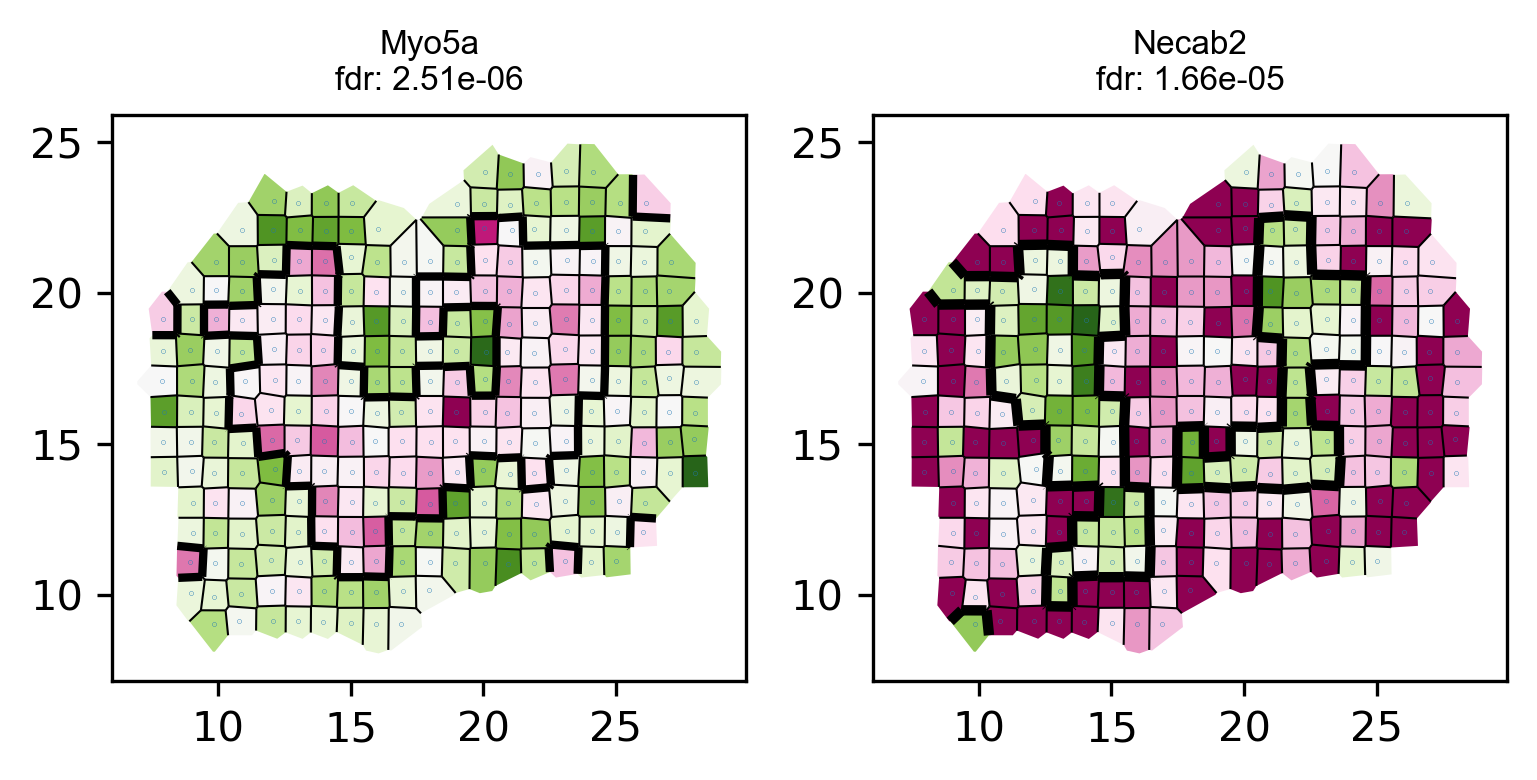

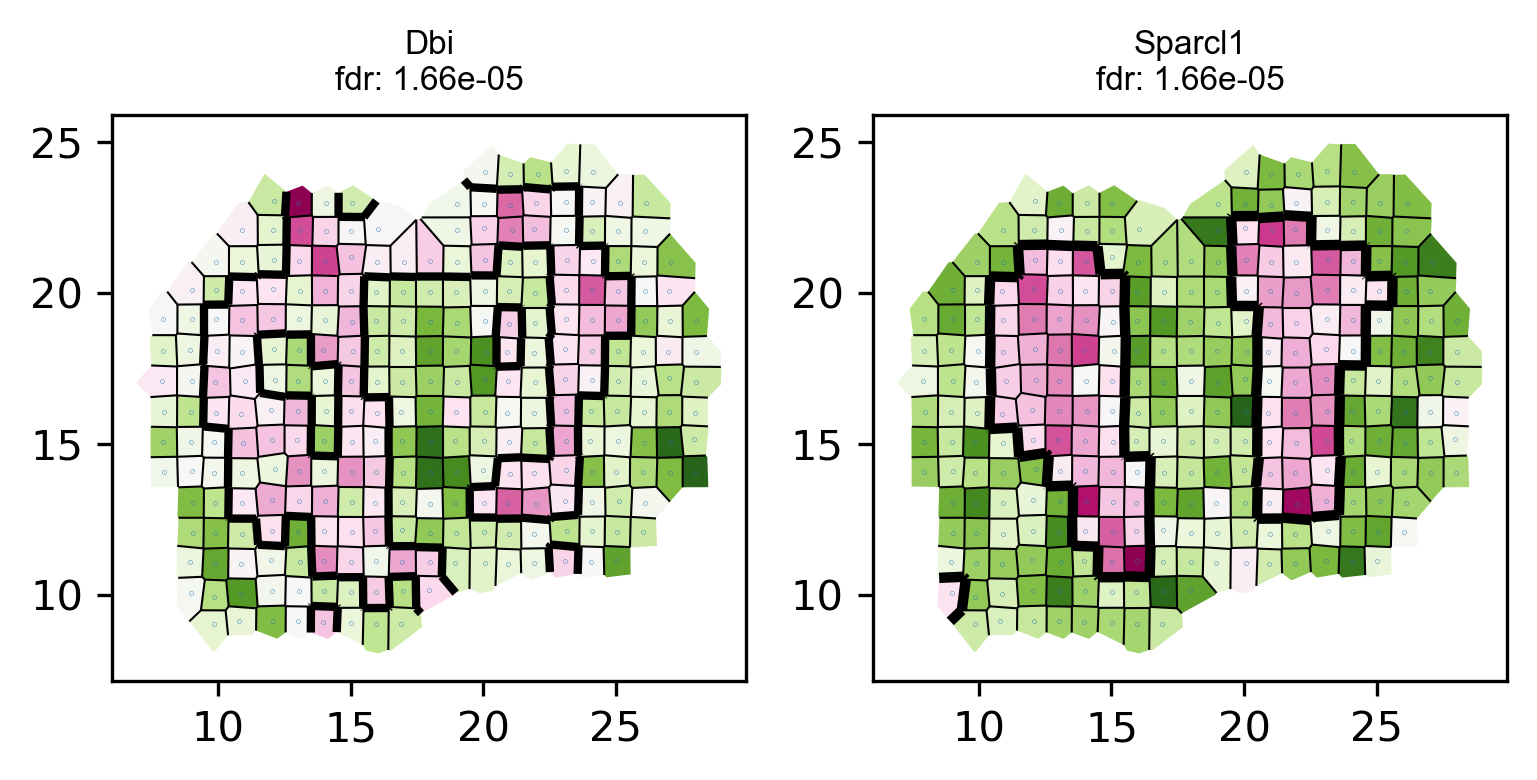

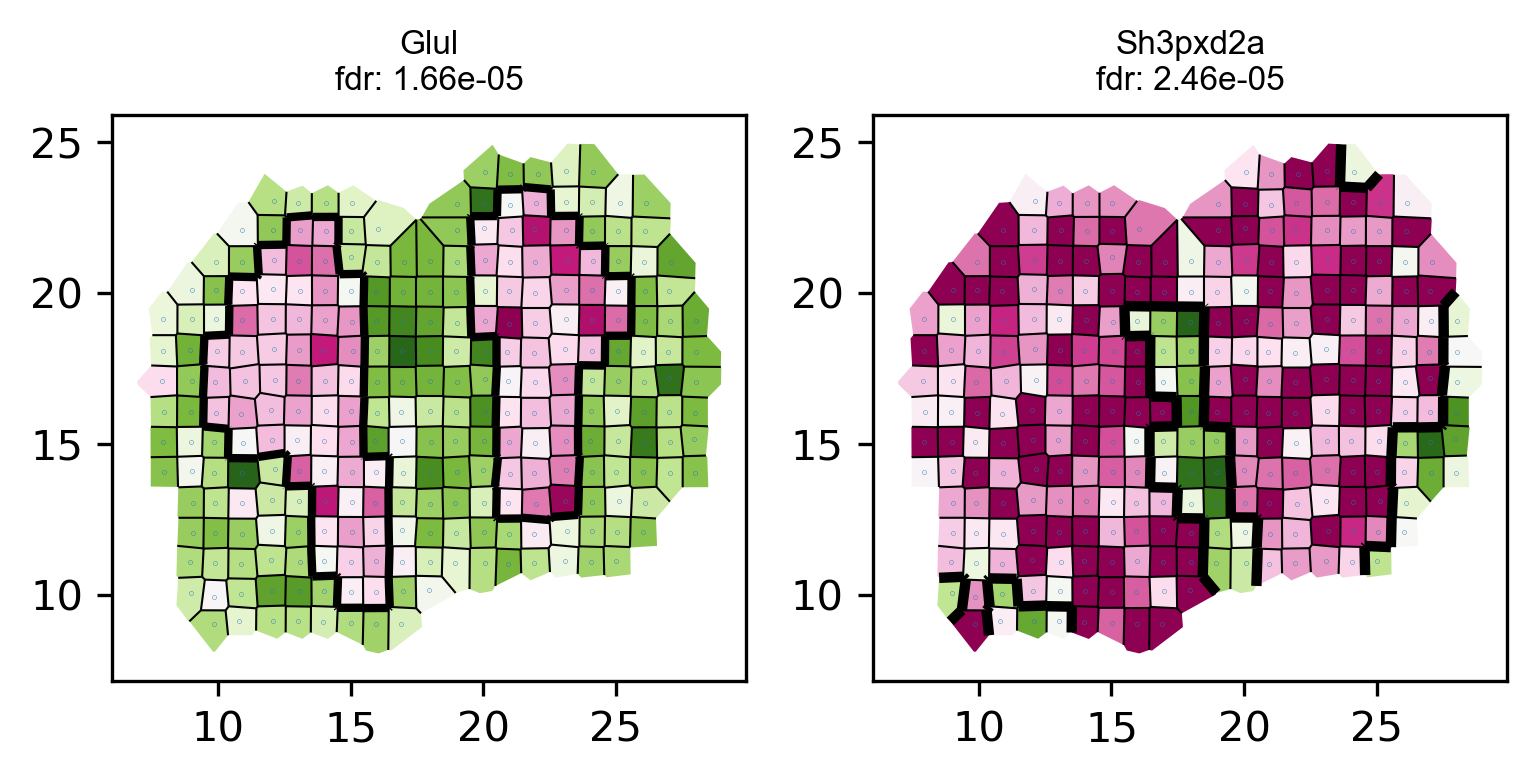

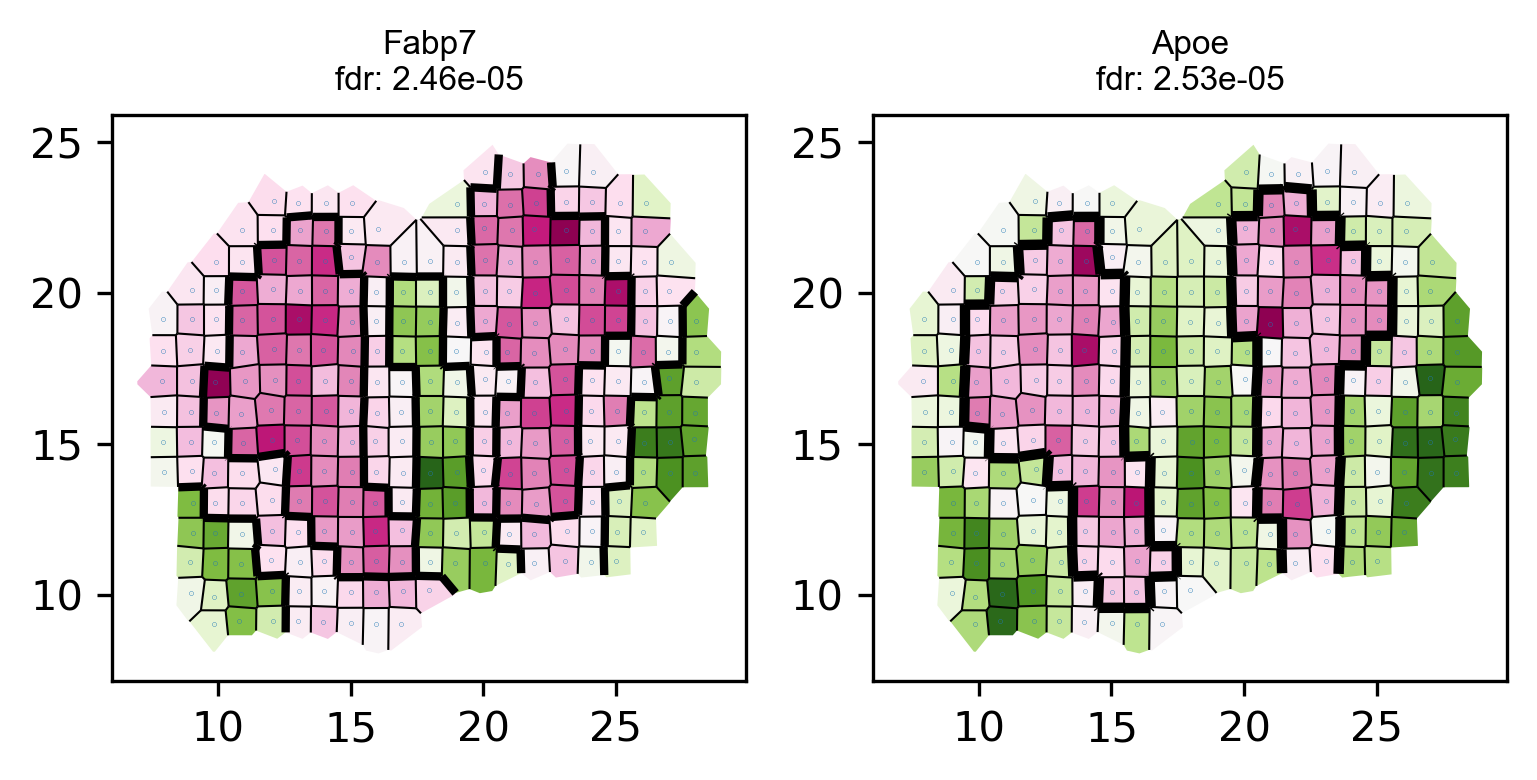

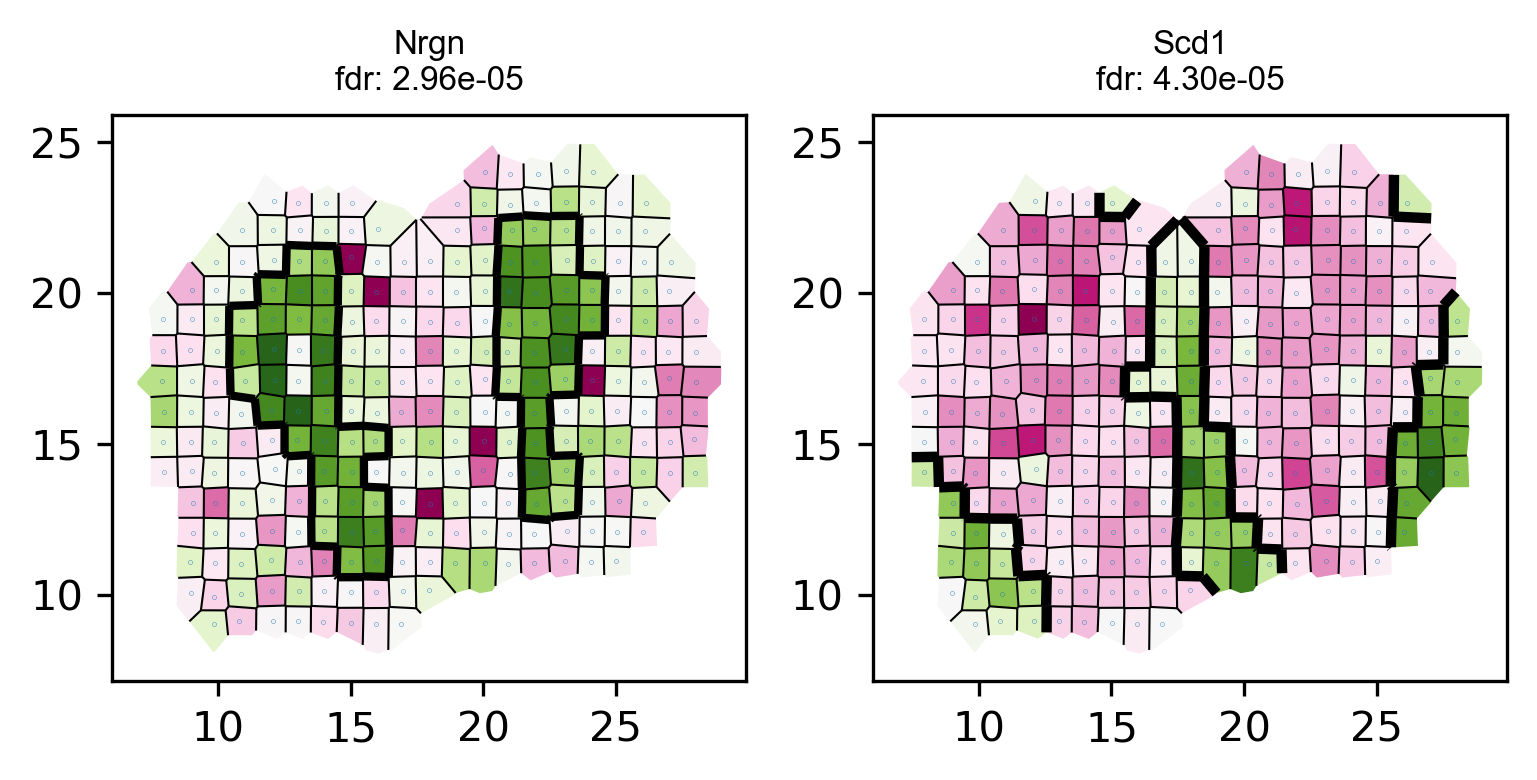

In [23]:
# visualize top genes
visualize_spatial_genes(fdr_df.iloc[0:10,], locs_new, data_norm_new ,point_size=0.2)


In [12]:
# save top genes to pdf
multipage_pdf_visualize_spatial_genes(fdr_df.iloc[0:10,], locs_new, data_norm_new,point_size=0) #, 
#                                       fileName='../../results//top10_genes.pdf')

## **Step 7:** 
<br><font size=4> **Perform t-SNE and visualize the clustering of identified genes.**<font>

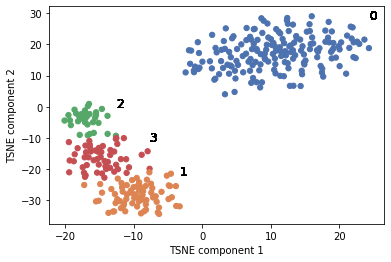

In [39]:
marker_genes = ['Pcp4','Apod','Slc17a7','Glul']
tsne_proj_df = spatial_pca_tsne_kmeans_cluster_gene(data_norm_new, 
                                                    fdr_df.index,
                                                    marker_genes, 
                                                    perplexity = 30,
                                                    fileName=None)
# plot_tsne(tsne_proj_df.iloc[:,0:2].values,tsne_proj_df.iloc[:,2]) #,
#           fileName='../../PDF_file/supple_figure/Fig2b.pdf')

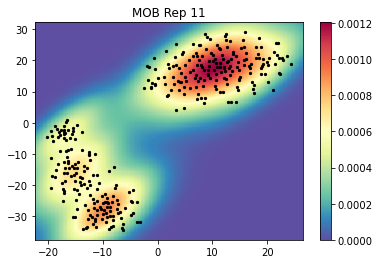

In [41]:

fig,ax = plt.subplots()

zz=visualize_tsne_density(tsne_proj_df.iloc[:,0:2].values,title=title,bins=200,threshold=0.1,ax=ax,fig=fig)

## **Step 8:** 

<br><font size=4>**Perform graph cuts for a single gene.**<font>

raw data dim: (262, 16218)


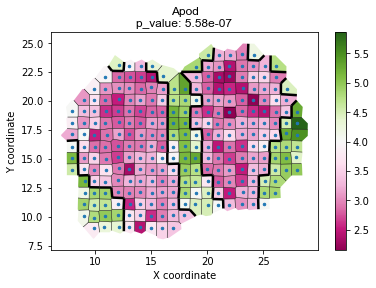

ERROR! Please supply a file name.


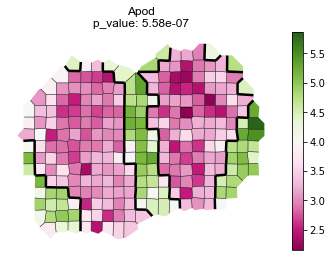

In [47]:
# You can also analyze one gene of interest

geneID='Apod' # Lets use Nrgn as an example
unary_scale_factor = 100 # scale factor for unary energy, default value works well
label_cost=10
algorithm='expansion'
# set smooth factor to 20 for example; 
# use bigger smooth_factor to get less segments
# use small smooth_factor to get more segments
smooth_factor=20 

ff = '../../data/Raw_data/MOB-breast_cancer/Rep11_MOB_count_matrix-1.tsv' 
# read in spatial gene expression data
locs, data = read_spatial_expression(ff,sep='\t')

# normalize gene expression
data_norm = normalize_count_cellranger(data)

# select anyone gene's expression
exp =  data_norm.iloc[:,0]

# create graph representation of spatial coordinates of cells
cellGraph = create_graph_with_weight(locs, exp)

## Fill spots
locs_new,data_norm_new,newPoints=AddPoints_XY_and_update_data(locs,data_norm,cellGraph,axis=1)

# recreate new cellGraph after filled sopts.
exp_new =  data_norm_new.iloc[:,0]
cellGraph_new = create_graph_with_weight(locs_new, exp_new)

        
# GMM 
count = data_norm_new.loc[:,geneID].values
gmm=perform_gmm(count)

# do graph cut
temp_factor=smooth_factor
newLabels = cut_graph_general(cellGraph_new, count, gmm, unary_scale_factor, 
                                           temp_factor, label_cost, algorithm)
# calculate p values
p, node, com = compute_p_CSR(locs_new, newLabels, gmm, count, cellGraph_new)

# Visualize graph cut results
plot_voronoi_boundary(geneID, locs_new, count,  newLabels, min(p)) 

# save the graph cut results to pdf
pdf_voronoi_boundary(geneID, locs_new, count, newLabels, min(p), 
                   fileName=None, #  '../../results//{}.pdf'.format(geneID),
                    point_size=0)
